In [1]:
from glob import glob

%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

import rasterio

# add the unet helpers
sys.path.append('../../')
from test_unet_helpers import *
from unet_models import unet11_MS

# torch stuff
import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models, datasets
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable

# data augmentation
import Augmentor

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expe

In [51]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val'

# aws pathts
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

class DG_GT_Dataset(Dataset):
    """Dataset class DG and GT data"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None, rot=False):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob.glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob.glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        self.rot = rot
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()
            
        #print(img_arr.shape, gt_arr.shape)

        # first consider the rotation argument
        if self.rot:
            dg_t = torch.from_numpy(img_arr)
            gt_t = torch.from_numpy(gt_arr)
            
            # get a random number
            rot_p = np.random.random()*100
            if rot_p < 35:
                
                dg_rot = dg_t.transpose(1,2)
                gt_rot = gt_t.transpose(1,2)
                
                return (dg_rot, gt_t)
            
            elif (rot_p >= 35) and (rot_p < 75):
                
                dg_rot = dg_t.flip(1).flip(2)
                gt_rot = gt_t.flip(1).flip(2)
                
                return (dg_rot, gt_rot)
                
            else:
            
                dg_rot = dg_t.transpose(1,2).flip(2) #t90 CCW
                gt_rot = gt_t.transpose(1,2).flip(2)
                
                return(dg_rot, gt_rot)
            


        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
            
        
    def __len__(self):
        return len(self.img_files)
    
    

In [52]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val'

# aws paths
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgrn1')
ps_train_ds_rot = DG_GT_Dataset(train_folder, channels='bgrn1', rot=True)

../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


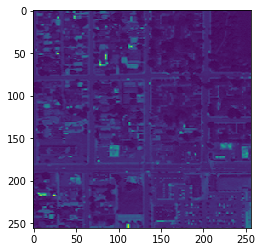

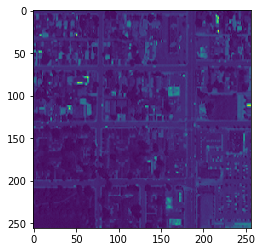

In [56]:
gt_base = ps_train_ds[0][1]
dg_base = ps_train_ds[0][0]

gt_rot = ps_train_ds_rot[0][1]
dg_rot = ps_train_ds_rot[0][0]

plt.imshow(dg_base[0])
plt.show()
plt.imshow(dg_rot[0]);

In [35]:
# do for one
files = glob.glob(train_folder + '/dg*.tif')
with rio.open(files[90]) as src:
    t = src.read()
    t = torch.from_numpy(t)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


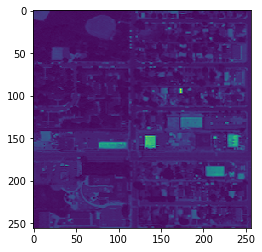

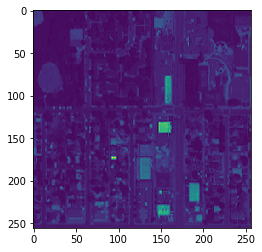

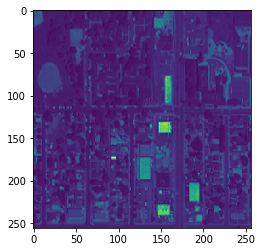

In [38]:
# x90 = x.transpose(2, 3)
# x180 = x.flip(2)
# x270 = x.transpose(2, 3).flip(3)

# x90 = x.transpose(0, 1).flip(0)
# x180 = x.flip(0).flip(1)
# x270 = x.transpose(0, 1).flip(1)

t90 = t.transpose(1,2) # flip on rows = 1, flip on cols = 2
t180 = t.flip(1).flip(2)
t270 = t.transpose(1,2).flip(2) #t90 CCW


plt.imshow(t[0])
plt.show()
plt.imshow(t90[0])
plt.show()
plt.imshow(t90[2])
plt.show()

In [ ]:
def stack_dg_transform(dgarr):
    temp=[]
    for a in dgarr:
        tens = transforms(torch.unsqueeze(torch.from_numpy(a), dim=0))
        temp.append(tens)
        
    return temp

tu = torch.unsqueeze(torch.from_numpy(t), dim=0)
ttu = stack_dg_transform(t)

plt.imshow(tu.numpy()[0][0])
plt.show()
plt.imshow(tt[0][0])
plt.show()

In [29]:
torch.tensor(np.arange(8)).view(2,2,2).shape

torch.Size([2, 2, 2])

In [46]:
np.random.random()*100

60.53445612420596